# COVID-19 LLM Feature Importance Visualization

The purpose of this notebook is to load our 120 (currently have 80/120) JSON files generated by the 3 LLMs for prompt engineering comparison, extracting feature importance weights, and visualizing trends across gender distributions, targets, and models.

In [1]:
#plotly import needs nbformat for inline visualization in jupyter notebook
! pip install nbformat


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports
import pandas as pd
import os
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

In [ ]:
# Load JSON files into DataFrame

#replace w unique path, my cloned repo is in a diff folder rn..
json_dir = r'C:\Users\nehan\Documents\GT\CS 4641\ML_vs_LLM_COVID_GenderBias\Feature Importance Output Files'
json_files = glob.glob(f"{json_dir}/*.json")

all_data = []

for filepath in json_files:
    filename = os.path.basename(filepath)
    llm, cotr, gender_dist, target = filename.replace(".json", "").split("_")

    with open(filepath, 'r') as f:
        feature_weights = json.load(f)

    for feature, weight in feature_weights.items():
        all_data.append({
            "LLM": llm,
            "COTR": cotr,
            "GenderDistribution": gender_dist,
            "Target Value": target,
            "Feature": feature,
            "Importance": weight
        })

df = pd.DataFrame(all_data)
df.head(2000)
df["LLM"].value_counts() #checking equal distribution of llms

df["Target Value"] = df["Target Value"].str.lower() #The naming method is inconsistent in capitalization (fix later)

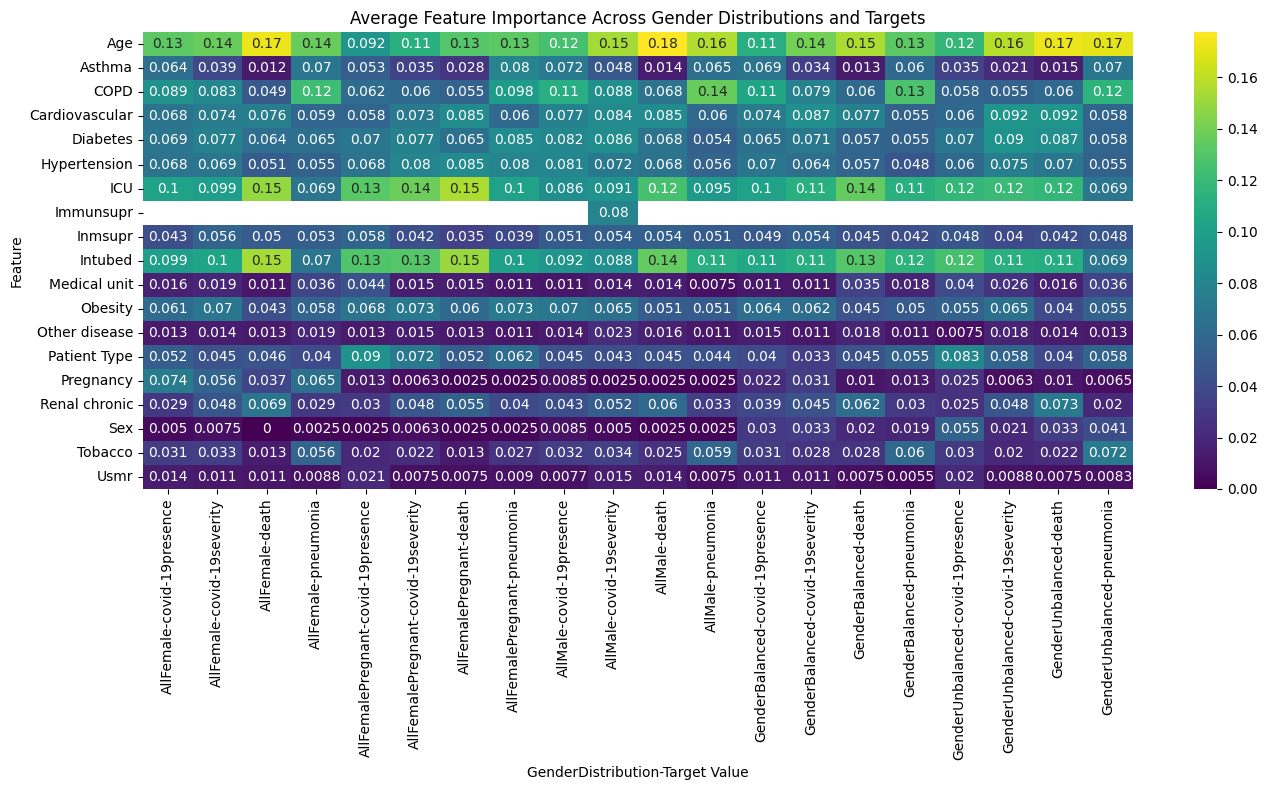

In [4]:
# Heatmap of Feature Importance Averages
pivot = df.pivot_table(values="Importance", 
                       index="Feature", 
                       columns=["GenderDistribution", "Target Value"], 
                       aggfunc="mean")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title("Average Feature Importance Across Gender Distributions and Targets")
plt.tight_layout()
plt.show()

In [5]:
#LLM Comparison Barplot
def plot_llm_comparison(target_col, gender_dist):
    subset = df[(df["Target Value"] == target_col) & (df["GenderDistribution"] == gender_dist)]
    plt.figure(figsize=(14, 6))
    sns.barplot(data=subset, x="Feature", y="Importance", hue="LLM")
    plt.title(f"Feature Importance by LLMs — Target Value: {target_col}, Gender: {gender_dist}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

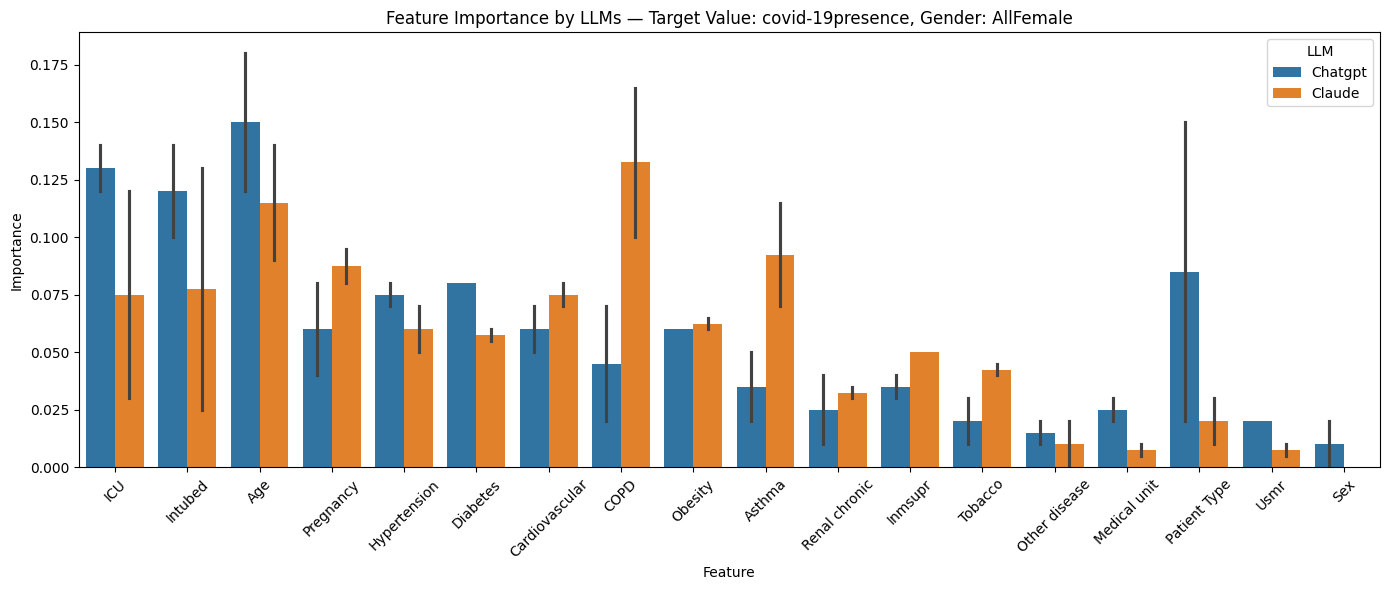

In [6]:
# Takes arguments: (Feature Value, Gender Distribution), plots as bar graph
#(lowercase wording require for ALL FEATURE VALUES)
plot_llm_comparison("covid-19presence", "AllFemale") 



In [7]:
# COTR Comparison for Specific Feature
def plot_cotr_comparison(feature, target_col):
    subset = df[(df["Feature"] == feature) & (df["Target Value"] == target_col)]
    sns.boxplot(data=subset, x="COTR", y="Importance", hue="LLM")
    plt.title(f"Effect of COTR on Feature '{feature}' Importance — Target: {target_col}")
    plt.tight_layout()
    plt.show()

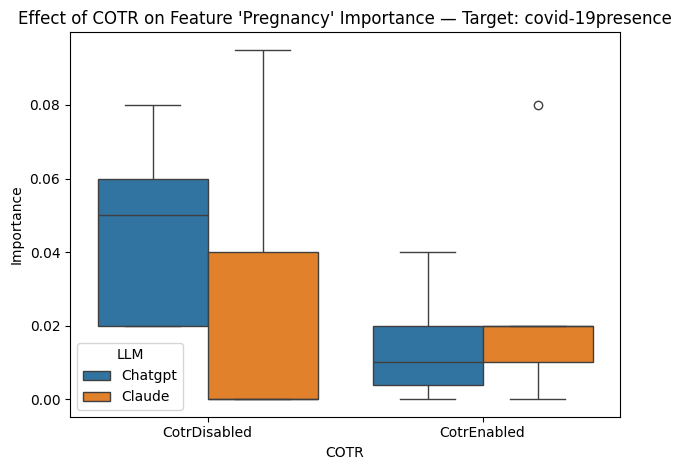

In [8]:
# Takes arguments: (Feature Value, Gender Distribution) and plots as bar graph
# feature needs to be LOWERCASE to adjust to data normalization
# for naming discrepancy
plot_cotr_comparison("Pregnancy", "covid-19presence")

In [ ]:
# bubble chart representation (just playing around)
fig = px.scatter(df,
                 x="Feature", y="Importance",
                 color="LLM",
                 size="Importance",
                 facet_col="Target Value",
                 facet_row="GenderDistribution",
                 hover_data=["COTR"])
fig.update_layout(title="Feature Importance Visualization")
fig.show()